<a href="https://colab.research.google.com/github/Zeenat101/Quantitative_bcg_matrix/blob/main/Quantitative_BCG_Matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.2 MB/s eta 0:00:00


Button(button_style='primary', description='Upload Excel', style=ButtonStyle())

Output()

Output()

Output()

Output()

Output()

✅ Ready. Upload Excel, pick X/Y, set single cuts (or keep 50%/50%), then Generate Matrix.


Saving Educated_vs_Rich_Users.xlsx to Educated_vs_Rich_Users.xlsx


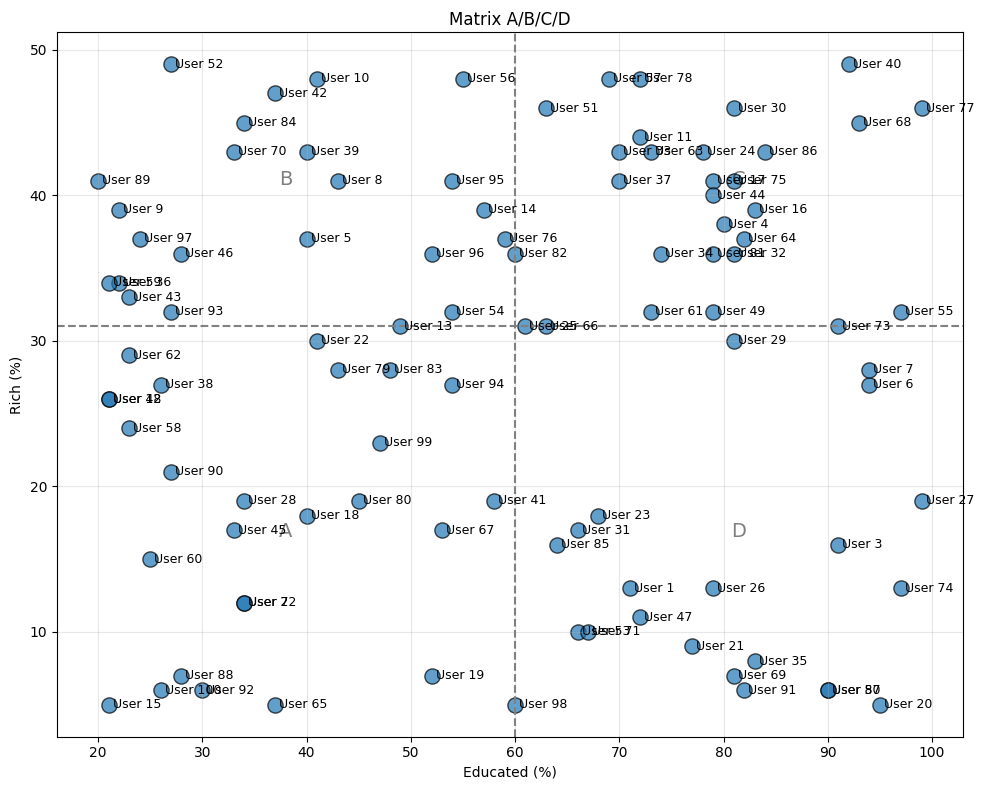

In [1]:
!pip -q install pandas numpy matplotlib openpyxl ipywidgets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import Dropdown, FloatText, Button, HBox, VBox, Output, RadioButtons, Label, Text
from IPython.display import display, clear_output
from google.colab import files

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["axes.grid"] = True

state = {"df": None, "sheets": None, "path": None}

# -------------------- Helpers --------------------
def _first_nonempty_header_row(df_raw: pd.DataFrame, min_nonempty=2):
    for i in range(len(df_raw)):
        row = df_raw.iloc[i]
        nonempty = row.map(lambda x: isinstance(x, str) and x.strip() != "" or pd.notna(x)).sum()
        if nonempty >= min_nonempty:
            return i
    return 0

def _load_sheet_robust(xls, sheet_name):
    raw = xls.parse(sheet_name, header=None)
    raw = raw.dropna(how="all")
    if raw.empty: return pd.DataFrame()
    hdr_idx = _first_nonempty_header_row(raw, min_nonempty=2)
    header = raw.iloc[hdr_idx].fillna("").astype(str).str.strip()
    df = raw.iloc[hdr_idx+1:].copy()
    df.columns = [c if c != "" else f"Col{j+1}" for j,c in enumerate(header)]
    df.columns = [str(c).strip() for c in df.columns]
    df = df.dropna(axis=1, how="all").dropna(how="all")
    return df

def _coerce_numeric(df, cols):
    for c in cols:
        if c and c in df.columns:
            df[c] = (df[c]
                     .astype(str)
                     .str.replace(r'[,\s]', '', regex=True)
                     .str.replace('%', '', regex=False))
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def quadrant_label_2x2(x, y, xcut, ycut):
    # A = bottom-left, B = top-left, C = top-right, D = bottom-right
    if x < xcut and y < ycut: return "A"
    if x < xcut and y >= ycut: return "B"
    if x >= xcut and y >= ycut: return "C"
    if x >= xcut and y < ycut: return "D"

# -------------------- Upload Excel --------------------
upload_btn = Button(description="Upload Excel", button_style="primary")
status_out = Output()
preview_out = Output()

def on_upload_clicked(_):
    with status_out:
        clear_output()
        print("📤 Choose an .xlsx file...")
    uploaded = files.upload()
    if uploaded:
        fname = list(uploaded.keys())[0]
        path = f"/content/{fname}"
        try:
            xls = pd.ExcelFile(path, engine="openpyxl")
            sheets = {name: _load_sheet_robust(xls, name) for name in xls.sheet_names}
            state["sheets"] = sheets
            state["path"] = path
            with status_out:
                print(f"✅ Uploaded: {fname}")
                print(f"Sheets detected: {list(sheets.keys())}")
            refresh_selectors()
            with preview_out:
                clear_output()
                for n, df in sheets.items():
                    print(f"\nPreview of '{n}' (first 5 rows):")
                    display(df.head())
        except Exception as e:
            with status_out:
                print(f"❌ Failed to read Excel: {e}")

upload_btn.on_click(on_upload_clicked)
display(upload_btn, status_out, preview_out)

# -------------------- UI controls --------------------
sheet_dd = Dropdown(description="Sheet:")
xcol_dd  = Dropdown(description="X Column:")
ycol_dd  = Dropdown(description="Y Column:")
label_dd = Dropdown(description="Labels:", options=[("None", None)], value=None)

mode_rb = RadioButtons(
    options=[("Auto (percentiles)", "auto"), ("Manual (set numbers)", "manual")],
    description="Mode:"
)

# Single-cut fields
x_cut_pct = FloatText(value=50.0, description="X Cut %:")  # default median
y_cut_pct = FloatText(value=50.0, description="Y Cut %:")
x_cut_val = FloatText(value=np.nan, description="X Cut:")
y_cut_val = FloatText(value=np.nan, description="Y Cut:")

title_box = Text(value="Matrix A/B/C/D", description="Chart Title:")
go_btn = Button(description="Generate Matrix", button_style="success")
ui_out, plot_out, table_out = Output(), Output(), Output()

def refresh_selectors():
    if state.get("sheets") is None: return
    valid = {k:v for k,v in state["sheets"].items() if not v.empty}
    state["sheets"] = valid
    sheet_dd.options = list(valid.keys())
    if sheet_dd.options:
        sheet_dd.value = sheet_dd.options[0]
        _fill_columns()

def _fill_columns(*args):
    if sheet_dd.value is None: return
    df = state["sheets"][sheet_dd.value]
    state["df"] = df
    cols = df.columns.tolist()
    xcol_dd.options = cols
    ycol_dd.options = cols
    label_dd.options = [("None", None)] + [(c, c) for c in cols]

sheet_dd.observe(_fill_columns, names="value")

display(VBox([
    Label("Pick your sheet & columns:"),
    HBox([sheet_dd]),
    HBox([xcol_dd, ycol_dd]),
    HBox([label_dd]),
    HBox([mode_rb]),
    Label("Auto uses percentiles; Manual uses numeric cut values."),
    HBox([x_cut_pct, y_cut_pct]),
    HBox([x_cut_val, y_cut_val]),
    HBox([title_box]),
    go_btn
]), ui_out, plot_out, table_out)

# -------------------- Generate --------------------
def on_generate_clicked(_):
    with ui_out: clear_output()
    with plot_out: clear_output()
    with table_out: clear_output()

    if state.get("df") is None:
        with ui_out: print("⚠️ Upload Excel first."); return

    df = state["df"].copy()
    xcol, ycol = xcol_dd.value, ycol_dd.value
    labcol = label_dd.value
    if not xcol or not ycol:
        with ui_out: print("⚠️ Please choose X Column and Y Column."); return

    # Coerce numerics
    df = _coerce_numeric(df, [xcol, ycol])
    df = df.dropna(subset=[xcol, ycol]).copy()
    if df.empty:
        with ui_out: print("⚠️ No rows with numeric X and Y after cleaning."); return

    # Compute single cuts
    if mode_rb.value == "manual":
        if np.isnan(x_cut_val.value) or np.isnan(y_cut_val.value):
            with ui_out: print("⚠️ Manual mode: provide both X Cut and Y Cut."); return
        xcut, ycut = float(x_cut_val.value), float(y_cut_val.value)
    else:
        try:
            xcut = np.percentile(df[xcol].astype(float).dropna(), float(x_cut_pct.value))
            ycut = np.percentile(df[ycol].astype(float).dropna(), float(y_cut_pct.value))
        except Exception as e:
            with ui_out: print(f"❌ Could not compute percentiles: {e}"); return
        # If user also typed manual numbers, let them override
        if not np.isnan(x_cut_val.value): xcut = float(x_cut_val.value)
        if not np.isnan(y_cut_val.value): ycut = float(y_cut_val.value)

    # Labels
    labels = df[labcol].astype(str) if labcol else df.index.astype(str)

    # Plot (one vertical + one horizontal line), uniform size
    fig, ax = plt.subplots()
    ax.scatter(df[xcol], df[ycol], s=120, alpha=0.7, edgecolors="black")
    ax.axvline(x=xcut, color="gray", linestyle="--")
    ax.axhline(y=ycut, color="gray", linestyle="--")

    # point labels
    for (x, y, t) in zip(df[xcol], df[ycol], labels):
        ax.text(x, y, f" {t}", fontsize=9, va="center")

    ax.set_xlabel(xcol); ax.set_ylabel(ycol); ax.set_title(title_box.value); ax.grid(True, alpha=0.3)

    # Quadrant letters (A/B/C/D)
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    centers = [
        ((xmin + xcut)/2,  (ymin + ycut)/2,  "A"),
        ((xmin + xcut)/2,  (ycut + ymax)/2,  "B"),
        ((xcut + xmax)/2,  (ycut + ymax)/2,  "C"),
        ((xcut + xmax)/2,  (ymin + ycut)/2,  "D"),
    ]
    for xc, yc, name in centers:
        ax.text(xc, yc, name, ha="center", va="center", fontsize=14, alpha=0.5)

    plt.tight_layout()

    # Summary table
    df["Quadrant"] = [quadrant_label_2x2(x,y,xcut,ycut) for x,y in zip(df[xcol], df[ycol])]
    summary = df["Quadrant"].value_counts().rename_axis("Quadrant").reset_index(name="Count")

    with plot_out: display(fig)
    with table_out:
        print("Quadrant counts:")
        display(summary)

go_btn.on_click(on_generate_clicked)

print("✅ Ready. Upload Excel, pick X/Y, set single cuts (or keep 50%/50%), then Generate Matrix.")